In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

In [2]:
with h5py.File('/work/hmzhao/irregular-lc/random-even-batch-1.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X_even = torch.tensor(dataset_file['X_even'][...])

In [3]:
# normalize
Y[:, 3:6] = torch.log(Y[:, 3:6])
mean_y = torch.mean(Y, axis=0)
std_y = torch.std(Y, axis=0)
std_mask = (std_y==0)
std_y[std_mask] = 1
# print(f'Y mean: {mean_y}\nY std: {std_y}')
Y = (Y - mean_y) / std_y
print(f'normalized Y mean: {torch.mean(Y)}\nY std: {torch.mean(torch.std(Y, axis=0)[~std_mask])}')

mean_x_even = torch.mean(X_even[:, :, 1], axis=0)
std_x_even = torch.std(X_even[:, :, 1], axis=0)
# print(f'X mean: {mean_x_even}\nX std: {std_x_even}')
X_even[:, :, 1] = (X_even[:, :, 1] - mean_x_even) / std_x_even
print(f'normalized X mean: {torch.mean(X_even[:, :, 1])}\nX std: {torch.mean(torch.std(X_even[:, :, 1], axis=0))}')
    

normalized Y mean: 7.889054489039284e-17
Y std: 0.9999999999999991
normalized X mean: -3.1350168683275113e-16
X std: 1.0000000000000004


tensor([ 0.0000,  0.0000, -0.7064, -0.0059, -0.3697, -0.4295,  1.3718],
       dtype=torch.float64)


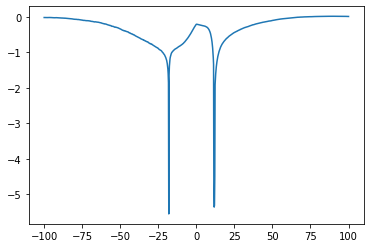

In [4]:
print(Y[5])
plt.plot(X_even[0, :, 0], X_even[5, :, 1])

# CDE Regression

In [5]:
from model.encoder_cde import CDEEncoder

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/experiment_38459.ckpt')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = Y.shape[-1]
input_dim = X_even.shape[-1]
latent_dim = ckpt_args.latents

model = CDEEncoder(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDEEncoder(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=65, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear2): PReLU(num_parameters=1)
        (linear3): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear2): PReLU(num_parameters=1)
        (linear3): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
    

In [6]:
import torchcde
# CDE interpolation
num = 128
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_even[:num])

In [7]:
model.eval()
pred = model(coeffs.float().to(device))

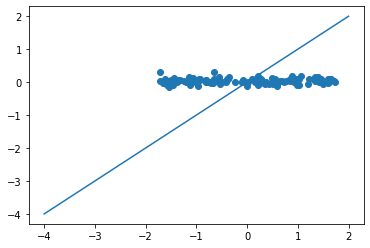

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(Y[:num, 3], pred.detach().cpu().numpy()[:, 3])
plt.plot(np.linspace(-4, 2), np.linspace(-4, 2))

# PROBLEM: cannot learn rho!

In [9]:
orig_sample_Y = Y[:num] * std_y + mean_y
orig_sample_pred = pred.detach().cpu() * std_y + mean_y

In [10]:
u0 = orig_sample_Y[:, 2]
log10q = orig_sample_Y[:, 4] / np.log(10)
log10s = orig_sample_Y[:, 5] / np.log(10)
alpha = orig_sample_Y[:, 6]
u0cosalpha = u0 * np.cos(alpha/180*np.pi)
u0sinalpha = u0 * np.sin(alpha/180*np.pi)

u0_pred = orig_sample_pred[:, 2]
log10q_pred = orig_sample_pred[:, 4] / np.log(10)
log10s_pred = orig_sample_pred[:, 5] / np.log(10)
alpha_pred = orig_sample_pred[:, 6]
u0cosalpha_pred = u0_pred * np.cos(alpha_pred/180*np.pi)
u0sinalpha_pred = u0_pred * np.sin(alpha_pred/180*np.pi)

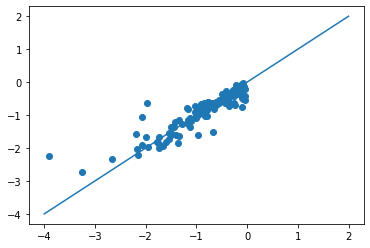

In [11]:
plt.scatter(log10q, log10q_pred)
plt.plot(np.linspace(-4, 2), np.linspace(-4, 2))

In [12]:
mse_log10q = torch.mean((log10q - log10q_pred)**2)
mse_log10s = torch.mean((log10s - log10s_pred)**2)
mse_u0cos = torch.mean((u0cosalpha - u0cosalpha_pred)**2)
mse_u0sin = torch.mean((u0sinalpha - u0sinalpha_pred)**2)
mse_u0 = torch.mean((u0 - u0_pred)**2)
mse_alpha = torch.mean((alpha - alpha_pred)**2)
print(f"mse of log10q: {mse_log10q}, mse of log10s: {mse_log10s}")
print(f"mse of u0cos_alpha: {mse_u0cos}, mse of u0sin_alpha: {mse_u0sin}")
print(f"mse of u0: {mse_u0}, mse of alpha: {mse_alpha}")

mse of log10q: 0.09292322150780213, mse of log10s: 0.0099045380170362
mse of u0cos_alpha: 0.08721122030166266, mse of u0sin_alpha: 0.05292903777860705
mse of u0: 0.008846677667572895, mse of alpha: 5678.756110701233


## irregular

In [13]:
with h5py.File('/work/hmzhao/irregular-lc/random-even-batch-1.h5', mode='r') as dataset_file:
    X_random = torch.tensor(dataset_file['X_random'][...])

In [23]:
X_random[0, :, 0], X_even[0, 4::5, 0]

(tensor([-98.8878, -98.5669, -96.5894, -96.5225, -96.5054, -95.1785, -94.6283,
         -94.1708, -93.8704, -93.8332, -92.2023, -91.5328, -89.6163, -87.8250,
         -87.5787, -85.2611, -85.2376, -83.4697, -81.0786, -79.9748, -79.7728,
         -79.4776, -78.5024, -78.0869, -77.7019, -76.2215, -75.7864, -75.1824,
         -73.0589, -73.0524, -70.7636, -68.8748, -66.4395, -66.1442, -61.7052,
         -61.3423, -60.4072, -59.6606, -56.6336, -56.1304, -55.3703, -55.2799,
         -53.2585, -52.1765, -49.9582, -49.7890, -48.8333, -48.4216, -48.2845,
         -46.4495, -45.9946, -42.8095, -41.1944, -40.7116, -40.5383, -38.9102,
         -38.8834, -38.7956, -38.0931, -38.0221, -30.1594, -29.7635, -29.2892,
         -28.9796, -28.2820, -27.7207, -26.8220, -24.4929, -21.2206, -20.8664,
         -19.9174, -19.0392, -19.0135, -16.9068, -16.6177, -15.1526, -13.6297,
         -12.3877, -10.4795, -10.1859,  -6.4125,  -6.4084,  -4.5009,  -1.7490,
          -1.1061,   2.4782,   2.5651,   4.3120,   4

In [16]:
mean_x_ran = torch.mean(X_random[:, :, 1], axis=0)
std_x_ran = torch.std(X_random[:, :, 1], axis=0)
X_random[:, :, 1] = (X_random[:, :, 1] - mean_x_ran) / std_x_ran
print(f'normalized X mean: {torch.mean(X_random[:, :, 1])}\nX std: {torch.mean(torch.std(X_random[:, :, 1], axis=0))}')

normalized X mean: -1.0424031415823266e-15
X std: 0.999999999999999


In [57]:
print(mean_x_even, std_x_even)
print(mean_x_ran, std_x_ran)

tensor([14.4388, 14.4384, 14.4380, 14.4376, 14.4373, 14.4369, 14.4366, 14.4362,
        14.4359, 14.4355, 14.4351, 14.4347, 14.4343, 14.4340, 14.4335, 14.4331,
        14.4327, 14.4323, 14.4319, 14.4315, 14.4311, 14.4307, 14.4303, 14.4299,
        14.4295, 14.4291, 14.4288, 14.4284, 14.4280, 14.4276, 14.4271, 14.4267,
        14.4263, 14.4258, 14.4254, 14.4250, 14.4245, 14.4240, 14.4236, 14.4231,
        14.4226, 14.4222, 14.4217, 14.4213, 14.4209, 14.4204, 14.4199, 14.4194,
        14.4190, 14.4185, 14.4181, 14.4176, 14.4171, 14.4166, 14.4162, 14.4157,
        14.4151, 14.4146, 14.4142, 14.4137, 14.4131, 14.4126, 14.4121, 14.4116,
        14.4111, 14.4106, 14.4101, 14.4094, 14.4089, 14.4084, 14.4079, 14.4073,
        14.4068, 14.4062, 14.4057, 14.4051, 14.4045, 14.4040, 14.4034, 14.4029,
        14.4022, 14.4017, 14.4011, 14.4006, 14.4000, 14.3995, 14.3989, 14.3983,
        14.3977, 14.3970, 14.3964, 14.3958, 14.3952, 14.3946, 14.3940, 14.3933,
        14.3928, 14.3922, 14.3915, 14.39

tensor([ 0.0000,  0.0000,  0.3197,  1.6100, -0.3334,  1.6951,  0.3585],
       dtype=torch.float64)


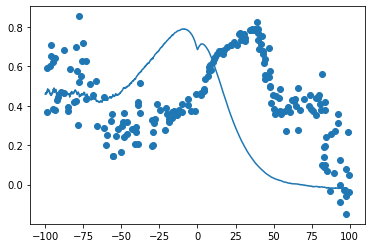

In [56]:
num = 0
print(Y[num])
plt.scatter(X_random[0, :, 0], X_random[num, :, 1])
plt.plot(X_even[0, :, 0], X_even[num, :, 1])

# Already checked dataset!

# PROBLEM: normalization differs dramatically!

In [60]:
num = 128
coeffs_ir = torchcde.hermite_cubic_coefficients_with_backward_differences(X_random[:num, :, :-1])
pred_ir = model(coeffs_ir.float().to(device))

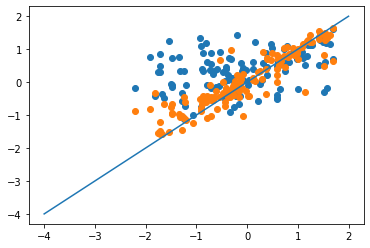

In [64]:
plt.scatter(Y[:num, 5], pred_ir.detach().cpu().numpy()[:, 5])
plt.scatter(Y[:num, 5], pred.detach().cpu().numpy()[:, 5])
plt.plot(np.linspace(-4, 2), np.linspace(-4, 2))

In [65]:
orig_sample_pred_ir = pred_ir.detach().cpu() * std_y + mean_y

u0_pred_ir = orig_sample_pred_ir[:, 2]
log10q_pred_ir = orig_sample_pred_ir[:, 4] / np.log(10)
log10s_pred_ir = orig_sample_pred_ir[:, 5] / np.log(10)
alpha_pred_ir = orig_sample_pred_ir[:, 6]
u0cosalpha_pred_ir = u0_pred_ir * np.cos(alpha_pred_ir/180*np.pi)
u0sinalpha_pred_ir = u0_pred_ir * np.sin(alpha_pred_ir/180*np.pi)

In [68]:
mse_log10q_ir = torch.mean((log10q - log10q_pred_ir)**2)
mse_log10s_ir = torch.mean((log10s - log10s_pred_ir)**2)
mse_u0cos_ir = torch.mean((u0cosalpha - u0cosalpha_pred_ir)**2)
mse_u0sin_ir = torch.mean((u0sinalpha - u0sinalpha_pred_ir)**2)
mse_u0_ir = torch.mean((u0 - u0_pred_ir)**2)
mse_alpha_ir = torch.mean((alpha - alpha_pred_ir)**2)
print('regular:')
print(f"mse of log10q: {mse_log10q}, mse of log10s: {mse_log10s}")
print(f"mse of u0cos_alpha: {mse_u0cos}, mse of u0sin_alpha: {mse_u0sin}")
print(f"mse of u0: {mse_u0}, mse of alpha: {mse_alpha}")
print('irregular:')
print(f"mse of log10q: {mse_log10q_ir}, mse of log10s: {mse_log10s_ir}")
print(f"mse of u0cos_alpha: {mse_u0cos_ir}, mse of u0sin_alpha: {mse_u0sin_ir}")
print(f"mse of u0: {mse_u0_ir}, mse of alpha: {mse_alpha_ir}")

regular:
mse of log10q: 0.09456826441867255, mse of log10s: 0.01136330205871436
mse of u0cos_alpha: 0.10250329839118404, mse of u0sin_alpha: 0.04535324242175581
mse of u0: 0.007649190333710417, mse of alpha: 5291.237012837681
irregular:
mse of log10q: 0.37727056262032344, mse of log10s: 0.060835727569925016
mse of u0cos_alpha: 0.14766450861044864, mse of u0sin_alpha: 0.11260937469276258
mse of u0: 0.024535698894573126, mse of alpha: 10650.82378549783


# LZR's results
## mse on ideal

loss(mse): 0.1

log10q: 0.3^2=0.09, log10s: 0.18^2=0.0324

## mse on realistic

loss(mse): 0.1

log10q: 0.0846, log10s: 0.0176

u0cos: 0.037, u0sin: 0.040

u0: 0.0176, alpha: 7441.306

# Generative ODE

In [5]:
from model.gen_ode import GenODE

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
input_dim = Y.shape[-1]
output_dim = X_even.shape[-1] - 1

checkpt = torch.load('/work/hmzhao/experiments/experiment_91672.ckpt')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

model = GenODE(ckpt_args, input_dim, output_dim, device).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

GenODE(
  (aug_net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=7, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (1): ResBlock(
      (linear1): Linear(in_features=256, out_features=1024, bias=True)
      (nonlinear1): Tanh()
      (linear2): Linear(in_features=1024, out_features=256, bias=True)
      (nonlinear2): Tanh()
      (linear3): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): ResBlock(
      (linear1): Linear(in_features=256, out_features=1024, bias=True)
      (nonlinear1): Tanh()
      (linear2): Linear(in_features=1024, out_features=256, bias=True)
      (nonlinear2): Tanh()
      (linear3): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ResBlock(
      (linear1): Linear(in_features=256, out_features=1024, bias=True)
      (nonlinear1): Tanh()
      (linear2): Linear(in_features=1024, out_features=256, bias=True)
      (nonlinear2): Tanh()

In [24]:
model.eval()
num = 9
pred = model(torch.tensor(Y[num].reshape(1, -1)).float().to(device), torch.tensor(X_even[0, :, 0]).float().to(device))

/var/tmp/pbs.76146.metis/ipykernel_2237054/2281277329.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(Y[num].reshape(1, -1)).float().to(device), torch.tensor(X_even[0, :, 0]).float().to(device))


tensor([ 0.0000, 50.0000,  1.8059, -0.8079,  0.0583,  0.9828, -1.4816],
       dtype=torch.float64)


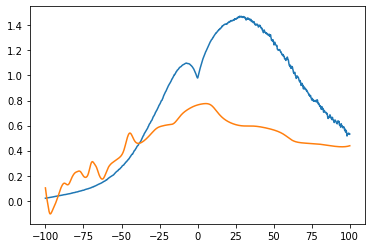

In [25]:
print(Y[num])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.plot(X_even[num, :, 0], pred.detach().cpu().numpy().flatten())

In [26]:
latent = model.aug_net(torch.tensor(Y[num].reshape(1, -1)).float().to(device))
print(latent)

tensor([[ 0.3719,  0.5745, -0.5689, -0.7571, -0.3540, -0.3572, -0.5003,  0.0472,
         -0.4456, -0.8231,  0.0650, -0.1645, -0.0868, -0.0801,  0.0713,  0.4275,
          0.1516,  0.3267, -0.3136, -0.2969,  0.2027, -0.5207, -0.5530,  0.4291,
          0.1795,  0.7403,  0.0014,  0.6046, -0.4481, -0.0197,  0.3870,  0.1702]],
       device='cuda:2', grad_fn=<TanhBackward>)


/var/tmp/pbs.76146.metis/ipykernel_2237054/3264624822.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent = model.aug_net(torch.tensor(Y[num].reshape(1, -1)).float().to(device))


In [27]:
initial_grad = model.ode_func(torch.tensor(-100).to(device), model.aug_net(torch.tensor(Y[num].reshape(1, -1)).float().to(device)))
print(initial_grad)

tensor([[ 0.6530, -0.0379, -0.8157, -0.6468, -0.0016,  0.4780, -0.6244,  0.7381,
         -0.3112, -0.7349, -0.6113, -0.1776,  0.2895,  0.5952,  0.1046, -0.0942,
          0.5388,  0.1250, -0.4205, -0.4357,  0.1152, -0.4637,  0.3835, -0.2316,
         -0.0043,  0.0744,  0.5310, -0.1046,  0.2542,  0.4332, -0.1092,  0.8952]],
       device='cuda:2', grad_fn=<TanhBackward>)


/var/tmp/pbs.76146.metis/ipykernel_2237054/837117711.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_grad = model.ode_func(torch.tensor(-100).to(device), model.aug_net(torch.tensor(Y[num].reshape(1, -1)).float().to(device)))


In [28]:
from torchdiffeq import odeint
sol = odeint(model.ode_func, latent, torch.tensor(X_even[0, :, 0]).float().to(device), method="dopri5",
            rtol=1e-7, atol=1e-9)

/var/tmp/pbs.76146.metis/ipykernel_2237054/3534019619.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sol = odeint(model.ode_func, latent, torch.tensor(X_even[0, :, 0]).float().to(device), method="dopri5",


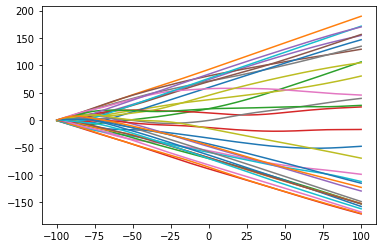

In [29]:
plt.plot(X_even[0, :, 0], sol.squeeze(1).detach().cpu())
plt.show()